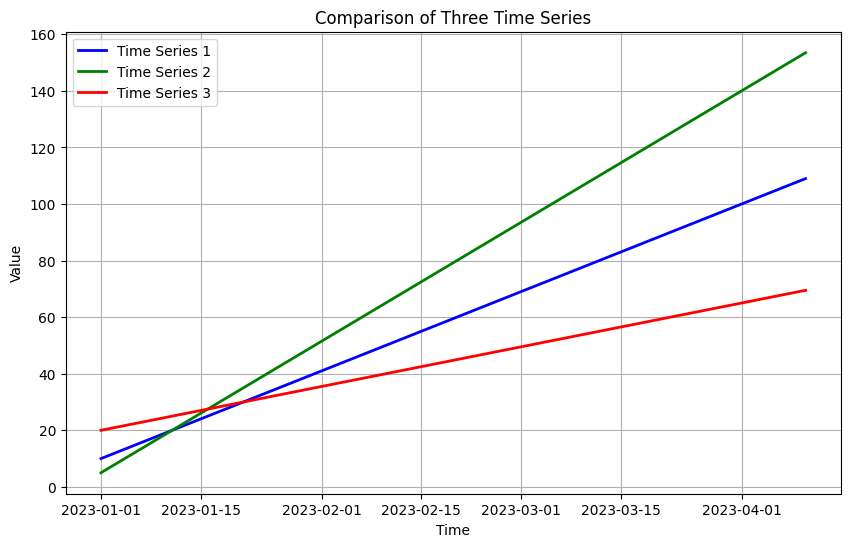

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data
time = pd.date_range(start='2023-01-01', periods=100, freq='D')
ts1 = [i + 10 for i in range(100)]  # Time series 1
ts2 = [i * 1.5 + 5 for i in range(100)]  # Time series 2
ts3 = [i * 0.5 + 20 for i in range(100)]  # Time series 3

# Plot all three time series
plt.figure(figsize=(10, 6))
plt.plot(time, ts1, label="Time Series 1", color='b', linewidth=2)
plt.plot(time, ts2, label="Time Series 2", color='g', linewidth=2)
plt.plot(time, ts3, label="Time Series 3", color='r', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Three Time Series')
plt.legend()

plt.grid(True)
plt.show()


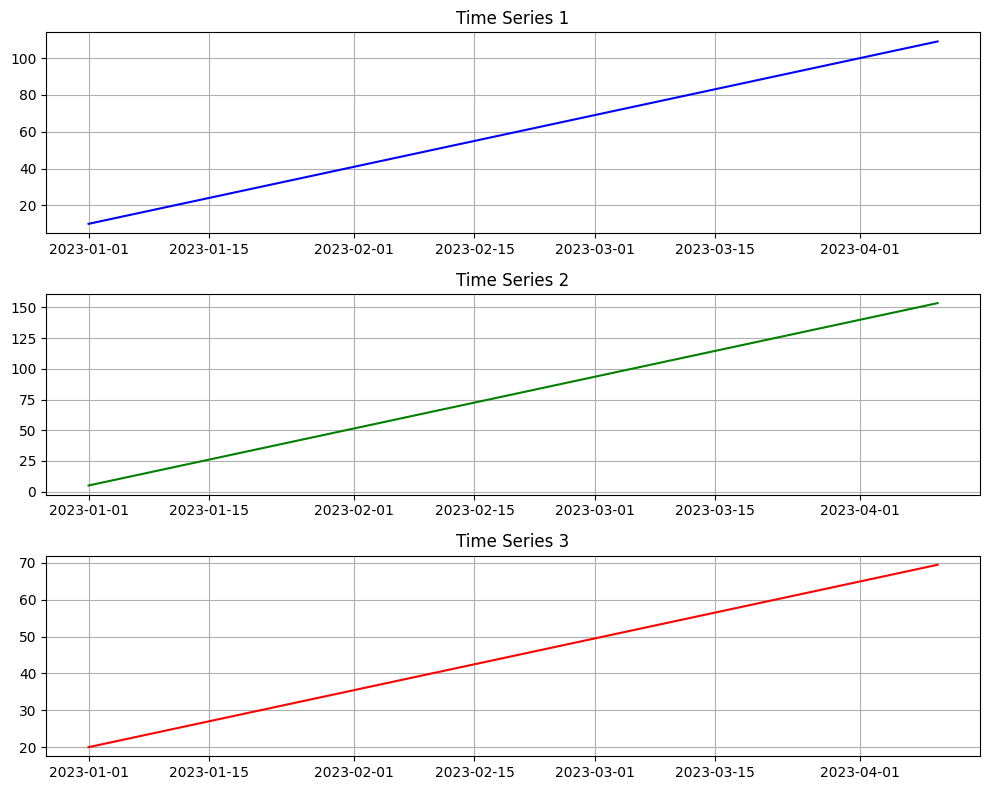

In [11]:
plt.figure(figsize=(10, 8))

# Subplot for Time Series 1
plt.subplot(3, 1, 1)
plt.plot(time, ts1, label="Time Series 1", color='b')
plt.title('Time Series 1')
plt.grid(True)

# Subplot for Time Series 2
plt.subplot(3, 1, 2)
plt.plot(time, ts2, label="Time Series 2", color='g')
plt.title('Time Series 2')
plt.grid(True)

# Subplot for Time Series 3
plt.subplot(3, 1, 3)
plt.plot(time, ts3, label="Time Series 3", color='r')
plt.title('Time Series 3')
plt.grid(True)

plt.tight_layout()
plt.show()


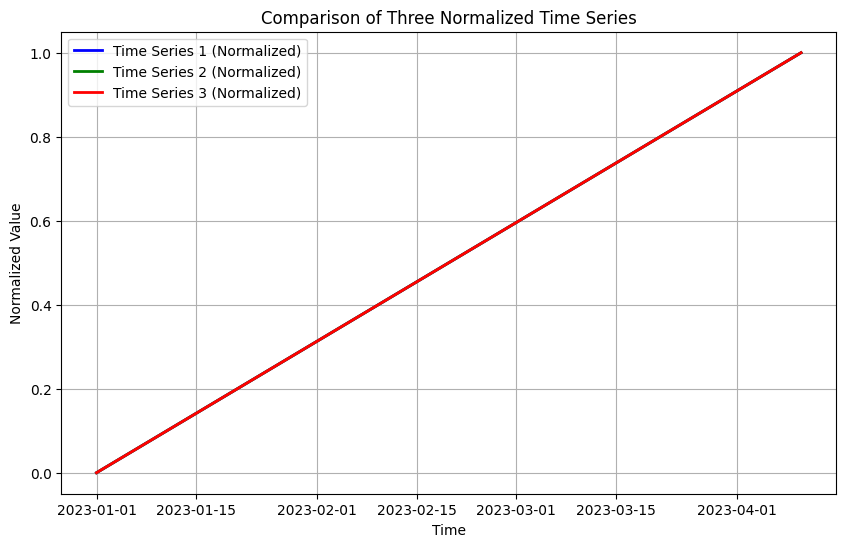

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Combine the time series into a DataFrame for easier manipulation
df = pd.DataFrame({'ts1': ts1, 'ts2': ts2, 'ts3': ts3})

# Normalize the time series
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

# Plot the normalized time series
plt.figure(figsize=(10, 6))
plt.plot(time, normalized_data[:, 0], label="Time Series 1 (Normalized)", color='b', linewidth=2)
plt.plot(time, normalized_data[:, 1], label="Time Series 2 (Normalized)", color='g', linewidth=2)
plt.plot(time, normalized_data[:, 2], label="Time Series 3 (Normalized)", color='r', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.title('Comparison of Three Normalized Time Series')
plt.legend()

plt.grid(True)
plt.show()


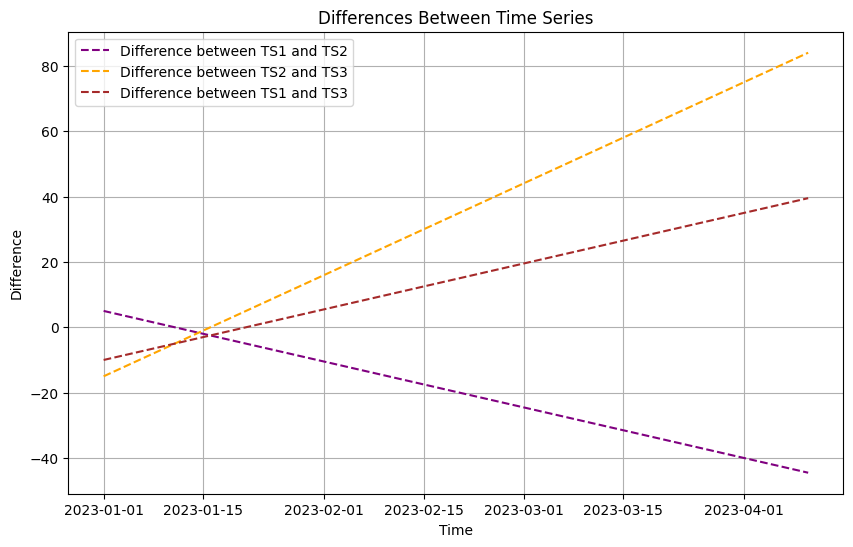

In [15]:
import numpy as np

plt.figure(figsize=(10, 6))

# Compute differences
diff_1_2 = np.array(ts1) - np.array(ts2)
diff_2_3 = np.array(ts2) - np.array(ts3)
diff_1_3 = np.array(ts1) - np.array(ts3)

# Plot differences
plt.plot(time, diff_1_2, label="Difference between TS1 and TS2", color='purple', linestyle='--')
plt.plot(time, diff_2_3, label="Difference between TS2 and TS3", color='orange', linestyle='--')
plt.plot(time, diff_1_3, label="Difference between TS1 and TS3", color='brown', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Differences Between Time Series')
plt.legend()

plt.grid(True)
plt.show()


In [16]:
a = []

In [18]:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] + ['a']

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'a']